# Load Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

from typing import Callable, Dict, List, Optional, Tuple, Union

import mne
from mne.io.edf.edf import RawEDF

from idtxl.active_information_storage import ActiveInformationStorage
from idtxl.multivariate_te import MultivariateTE
from idtxl.results import ResultsSingleProcessAnalysis, ResultsNetworkInference
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

DEBUG:root:test
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
def read_data(data_path: str) -> RawEDF:
    raw = mne.io.read_raw_edf(data_path, preload=True)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    return raw

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


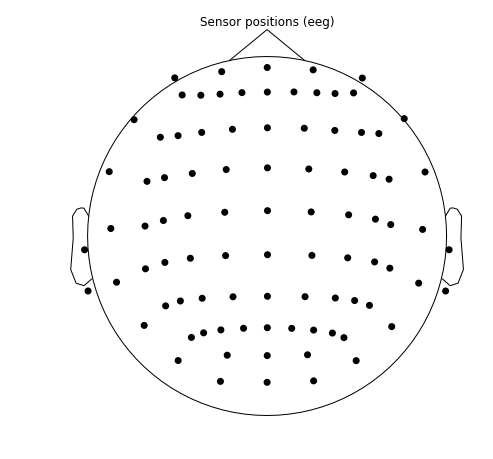

Extracting EDF parameters from /home/jarajaras/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...


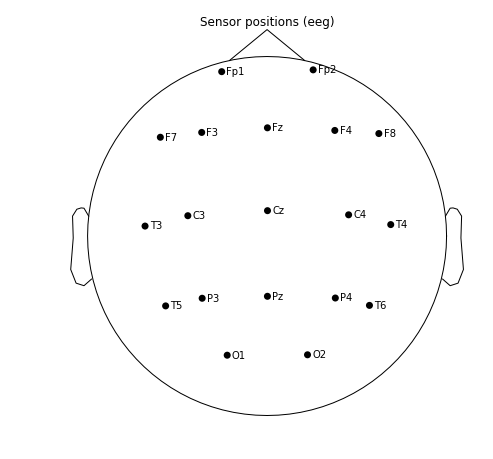

In [4]:
# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
montage.plot(kind='topomap', show_names=False)
plt.show()

# Verify montage
raw = read_data('../data/h01.edf')
raw.plot_sensors(show_names=True)
plt.show()

In [5]:
# Read data
dataS = read_data('../data/s01.edf')
dataH = read_data('../data/h01.edf')

Extracting EDF parameters from /home/jarajaras/dynamicinfo-eeg/data/s01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 211249  =      0.000 ...   844.996 secs...
Extracting EDF parameters from /home/jarajaras/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...


In [37]:
from utils.read_data import read_data
from utils.re_referencing import rref_REST, rref_remove, rref_CSD, rref_average
from utils.data_filtering import filter_band_raw_to_raw, filter_band_raw_to_array
from utils.data_filtering import clean_windows_artifacts, reconstruct_signal, create_windows

raw_filtered = filter_band_raw_to_raw(dataH, [0.1, 100])
all_data_second = filter_band_raw_to_array(raw_filtered, [0.1, 100])
all_data = filter_band_raw_to_array(raw_filtered, None)

data_windows, all_data, data_windows_not_filt_but0100, all_data_not_filt_but0100 = create_windows(
    raw_filtered, 
    time=10, band=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8251 samples (33.004 sec)



INFO:root:Please use a band in filter_bands=dict_keys(['alpha', 'beta', 'gamma', 'theta'])
INFO:root:Please use a band in filter_bands=dict_keys(['alpha', 'beta', 'gamma', 'theta'])


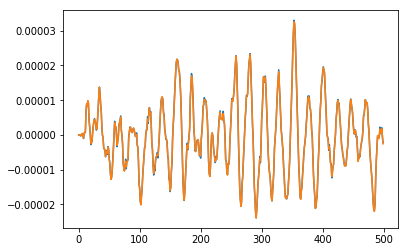

In [41]:
plt.plot(data_windows[0][-1][:500])
plt.plot(data_windows_not_filt_but0100[0][-1][:500])

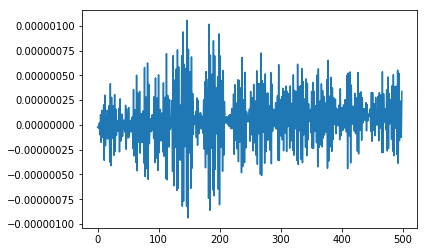

In [43]:
plt.plot(data_windows[0][-1][:500] - data_windows_not_filt_but0100[0][-1][:500])

In [24]:
print(all_data[-1, :20])
print(all_data_second[-1, :20])

[ 2.96461532e-21  8.62088038e-09 -3.70058079e-08 -2.54209815e-07
 -2.52323601e-07  2.82144163e-07  2.77143470e-07 -7.01205664e-08
 -1.04778359e-06  4.92895573e-07  6.98228872e-07  7.03118902e-07
  6.78223511e-06  8.77332116e-06  8.22316957e-06  9.73633604e-06
  9.13419624e-06  4.38598150e-06  2.43272560e-06  4.14580964e-07]
[ 2.15962511e-08  2.75732781e-08 -3.10895960e-09 -2.74103335e-07
 -1.52155251e-07  1.78595939e-07  4.52713185e-07 -2.16237134e-07
 -9.21154553e-07  5.43576597e-07  4.96494517e-07  1.06016017e-06
  6.48267542e-06  8.98337776e-06  8.13011720e-06  9.86970025e-06
  8.98623458e-06  4.52917553e-06  2.46021246e-06  2.20589142e-07]


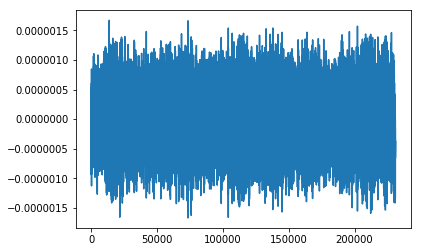

In [29]:
plt.plot((all_data - all_data_second)[-3, :])

In [45]:
print(dataS.info.ch_names)

['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']


Idx | Name Channel
----|-------------
  0 | Fp2
  1 | F8
  2 | T4
  3 | T6
  4 | O2
  5 | Fp1
  6 | F7
  7 | T3
  8 | T5
  9 | O1
 10 | F4
 11 | C4
 12 | P4
 13 | F3
 14 | C3
 15 | P3
 16 | Fz
 17 | Cz
 18 | Pz
Extracting EDF parameters from /home/jarajaras/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...


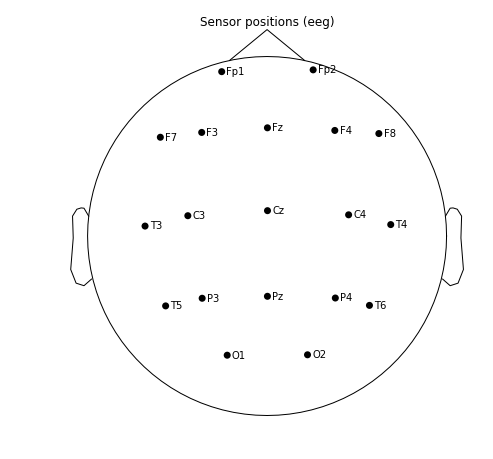

In [44]:
print('Idx | Name Channel')
print('----|-------------')
for i,j in enumerate(dataS.ch_names):
    print('%3d | %s'%(i,j))
    
# Verify montage
raw = read_data('../data/h01.edf')
raw.plot_sensors(show_names=True)
plt.show()

# Visualization

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=5.789999999999999 to DejaVu Sans ('/home/jarajaras/anaconda3/envs/eeg-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


Schizophrenic EEG (Raw)


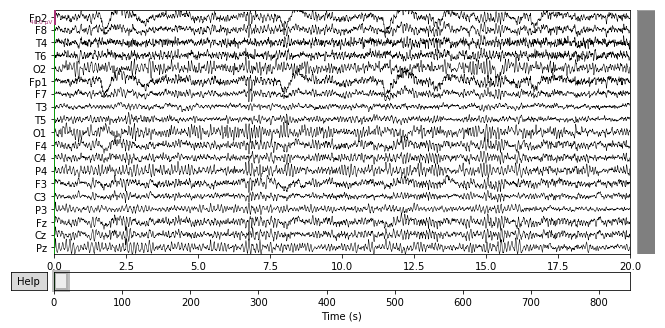

Healthy EEG (Raw)


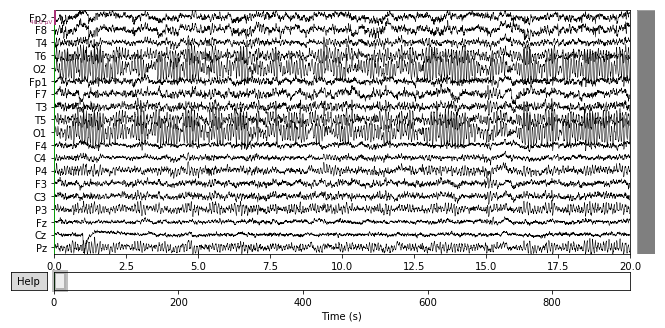

Schizophrenic EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



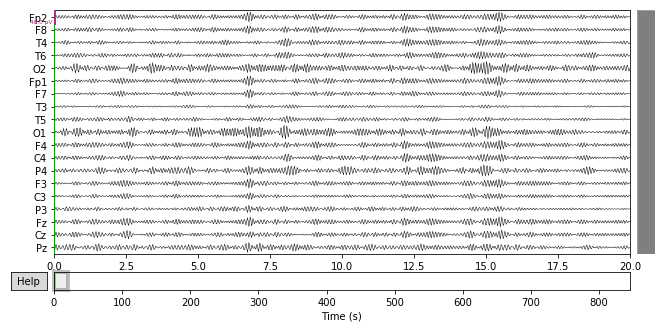

Health EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



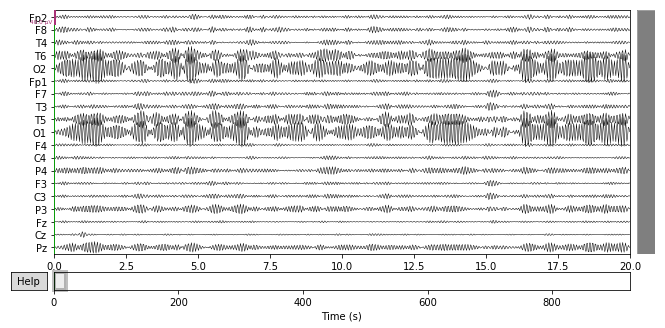

In [7]:
print('Schizophrenic EEG (Raw)')
dataS.plot(duration=20,title="Schizophrenic EEG (Raw)")

print('Healthy EEG (Raw)')
dataH.plot(duration=20,title="Healthy EEG (Raw)")

print('Schizophrenic EEG (Alpha band)')
dataS.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Schizophrenic EEG (Alpha band)")

print('Health EEG (Alpha band)')
dataH.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Healthy EEG (Alpha band)")

plt.show()

# Re-referencing

In [8]:
# https://github.com/mne-tools/mne-python/blob/master/examples/preprocessing/plot_rereference_eeg.py

def rref_remove(raw: RawEDF) -> RawEDF:
    raw = raw.copy()
    raw, _ = mne.set_eeg_reference(raw, [])
    return raw

def rref_average(raw: RawEDF, projection: Optional[bool] = False) -> RawEDF:
    """
    Re-referencing using AVERAGE method.
    """
    raw = raw.copy()
    raw.set_eeg_reference('average', projection=projection)
    return raw

def rref_CSD(raw: RawEDF) -> RawEDF:
    """
    Re-referencing using CSD method.
    """
    raw = raw.copy()
    raw = raw.pick_types(meg=False, eeg=True, eog=True, ecg=True, stim=True,
                     exclude=raw.info['bads']).load_data()
    raw.set_eeg_reference(projection=True).apply_proj()
    raw = mne.preprocessing.compute_current_source_density(raw)
    return raw

def rref_REST(raw: RawEDF) -> RawEDF:
    """
    Re-referencing using REST method.
    """
    raw = raw.copy()
    sphere = mne.make_sphere_model('auto', 'auto', raw.info, verbose=False)
    src = mne.setup_volume_source_space(sphere=sphere, exclude=30.,
                                        pos=15., verbose=False)  # large "pos" just for speed!
    forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere, verbose=False)
    raw.set_eeg_reference('REST', forward=forward, verbose=False)
    return raw

In [9]:
raw = read_data('../data/h01.edf')
raw_average = rref_average(raw)
raw_csd = rref_CSD(raw)
raw_rest = rref_REST(raw)

Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Fitted sphere radius:         91.5 mm
Origin head coordinates:      0.8 7.9 50.3 mm
Origin device coordinates:    0.8 7.9 50.3 mm


DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


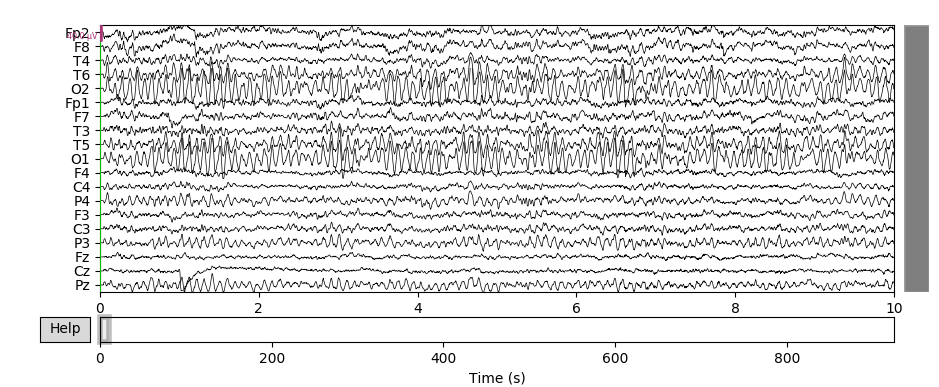

<IPython.core.display.Javascript object>


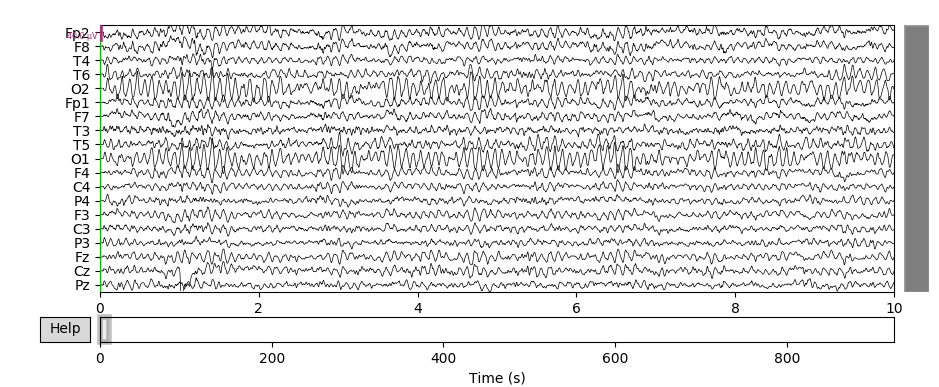

Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


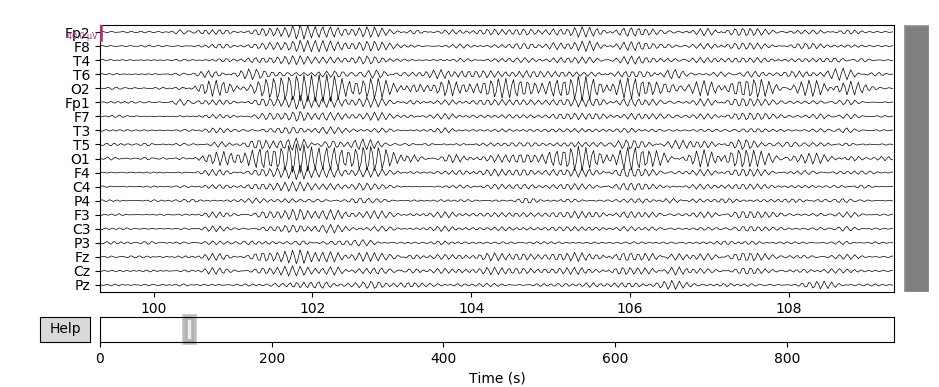

In [12]:
%matplotlib notebook
raw.plot(title="raw")
#raw_average.plot()
#raw_csd.plot()
raw_rest.plot(title="REST")
raw_rest.plot(lowpass=12.5, highpass=8, filtorder=2, title="REST (Alpha band)")

plt.show()

In [11]:
%matplotlib inline

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


# Filter data

In [12]:
def filter_band(raw_edf: RawEDF, band: Optional[str] ='alpha', verbose: Optional[bool] = False) -> List:
    """
    Method description.
    """
    BANDS = {
        "alpha": [8, 12.5],
        "beta": [13, 30],
        "gamma": [30, 45],
        "theta": [4.5, 7.5]
    }
    
    if not band:
        logger.info(f"Please use a band in filter_bands={BANDS.keys()}")
        return raw_edf.get_data()
    
    l_freq, h_freq  = BANDS.get(band.lower(), (None, None))
    
    if (not h_freq) or (not l_freq):
        logger.info(f"Check your band={band}, not in filter_bands={BANDS.keys()}")
        return raw_edf.get_data()
    
    return mne.filter.filter_data(
        raw_edf.get_data(), raw_edf.info['sfreq'],
        l_freq=l_freq, 
        h_freq=h_freq,
        method='iir',
        iir_params=dict(order=2, ftype='butter'),
        verbose=verbose
    )

def create_windows(raw_edf: RawEDF, time: Optional[int] = 5, band: str = 'alpha') -> Tuple[List, List]:
    """
    Return data filtered by band.
    """
    # Filter all data by band
    all_data = filter_band(raw_edf, band)
    # Creating windows
    n_samples = int(raw_edf.info['sfreq']*time)
    n_windows = int(all_data.shape[-1]/n_samples)
    data_windows = np.array([all_data[:, (i_window*n_samples):((i_window+1)*n_samples)] 
                    for i_window in range(n_windows)])
    return data_windows, all_data

def plot_channel_by_window(
    raw_edf: RawEDF, 
    time: Optional[int] = 5, 
    i_channel: Optional[int] = 0, 
    i_window: Optional[int] = 0, 
    band: Optional[str] = 'alpha',
    **kwargs: Optional[Dict]):
    """
    Plot by channel and window.
    """
    rref_fn = kwargs.get("rref_fn", None)
    if rref_fn:
        raw_ref = rref_fn(raw_edf)
        data_windows_ref, _ = create_windows(raw_ref, time, band)
    data_windows, all_data = create_windows(raw_edf, time, band)
    n_windows, n_channels, n_samples = data_windows.shape
    tt = np.linspace(0, time, n_samples)+((i_window)*time)
    # Plotting
    plt.figure(figsize=(10,4))
    plt.plot(tt, raw_edf.get_data()[i_channel, (i_window*n_samples):((i_window+1)*n_samples)], label='Original')
    plt.plot(tt, data_windows[i_window, i_channel, :], label='Filtered (%s band)' % (band) if filter_band else "Signal")
    if rref_fn:
        plt.plot(tt, data_windows_ref[i_window, i_channel, :], label=f'{rref_fn.__name__} + filtered ({band})' if filter_band else "Signal")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Channel %s.' % (raw_edf.ch_names[i_channel]) + kwargs.get("title", ""))
    plt.legend()
    plt.grid()
    plt.show()

# Drop artifacts (window dirty)

In [13]:
def get_statistics(raw: RawEDF, i_channel: Optional[int] = 16, **kwargs: Optional[Dict]) -> Tuple:
    rref_fn = kwargs.get("rref_fn", None)
    if rref_fn:
        _, all_data = create_windows(rref_fn(raw))
    else: 
        _, all_data = create_windows(raw)
    RMS = np.sqrt(((all_data[i_channel])**2).mean())
    return RMS, all_data[i_channel].std()
# Statics
RMS_H, std_H = get_statistics(dataH, 16, **{"rref_fn": rref_REST})
RMS_S, std_S = get_statistics(dataS, 16, **{"rref_fn": rref_REST})
print("HEALTH RMS:", RMS_H)
print("SZ RMS:", RMS_S)
print("HEALTH std:", std_H)
print("SZ std:", std_S)

HEALTH RMS: 5.330678622648674e-06
SZ RMS: 2.8356669239487546e-06
HEALTH std: 5.330678622648349e-06
SZ std: 2.8356669228432424e-06


Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



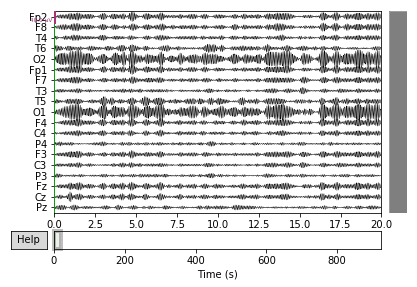

Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



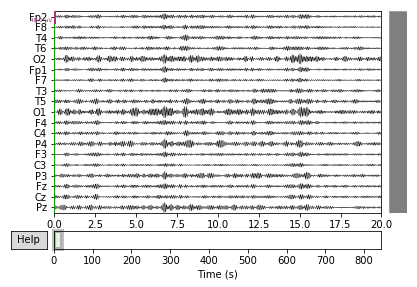

In [14]:
rref_REST(dataH).plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Healthy EEG (Alpha band)")
rref_REST(dataS).plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Schizophrenic EEG (Alpha band)")

plt.show()

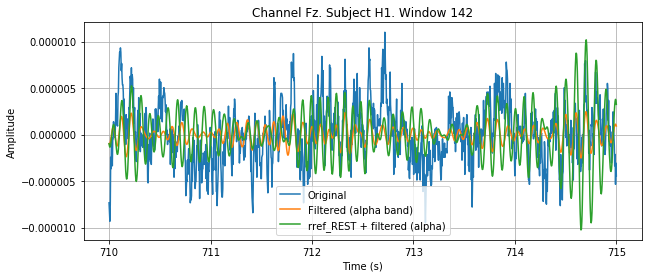

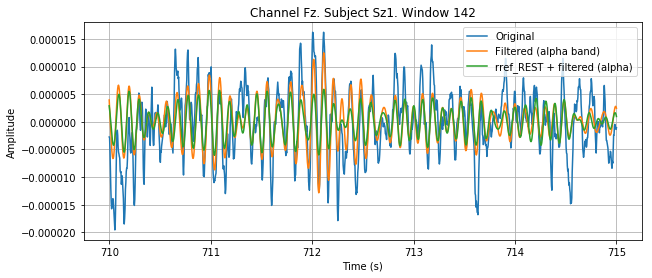

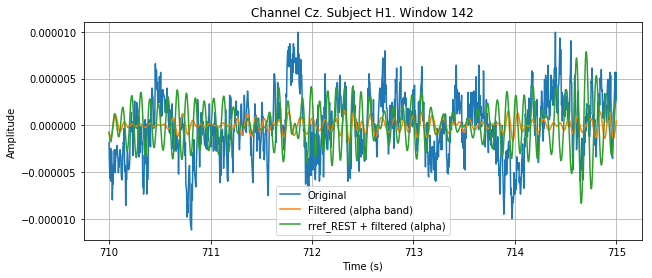

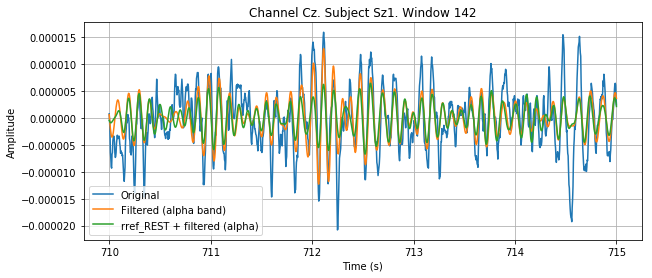

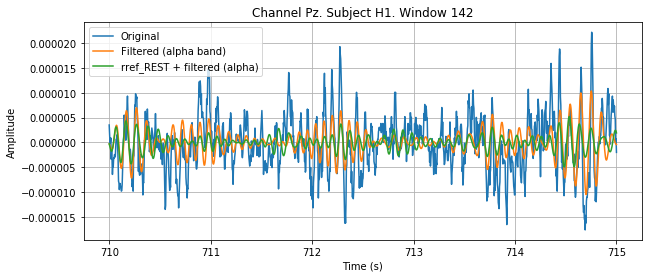

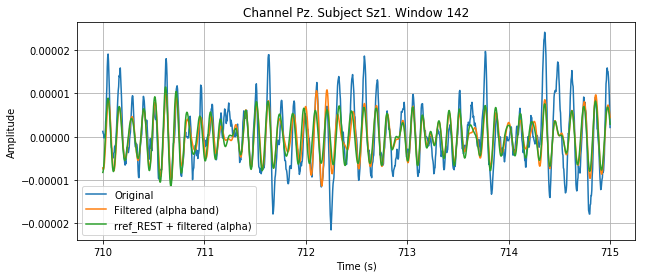

In [15]:
# WARNING: Different windows for dataH and dataS
i_window = 142

# Plotting for Fz, Cz and Pz
plot_channel_by_window(dataH, i_channel=16, i_window=i_window, band="alpha", **{"title": f" Subject H1. Window {i_window}", "rref_fn": rref_REST})
plot_channel_by_window(dataS, i_channel=16, i_window=i_window, band="alpha", **{"title": f" Subject Sz1. Window {i_window}", "rref_fn": rref_REST})
#plot_channel_by_window(raw, i_channel=16, i_window=i_window, band="alpha")

plot_channel_by_window(dataH, i_channel=17, i_window=i_window, band="alpha", **{"title": f" Subject H1. Window {i_window}", "rref_fn": rref_REST})
plot_channel_by_window(dataS, i_channel=17, i_window=i_window, band="alpha", **{"title": f" Subject Sz1. Window {i_window}", "rref_fn": rref_REST})
#plot_channel_by_window(raw, i_channel=17, i_window=i_window, band="alpha")

plot_channel_by_window(dataH, i_channel=18, i_window=i_window, band="alpha", **{"title": f" Subject H1. Window {i_window}", "rref_fn": rref_REST})
plot_channel_by_window(dataS, i_channel=18, i_window=i_window, band="alpha", **{"title": f" Subject Sz1. Window {i_window}", "rref_fn": rref_REST})
#plot_channel_by_window(raw, i_channel=18, i_window=i_window, band="alpha")

# Network analyser

In [16]:
def analyse_network_by_metric(
    data_window: List, 
    channels: Union[int, List[int]],
    metric: str, 
    **settings: Optional[Dict[str, float]]) -> Union[ResultsSingleProcessAnalysis, ResultsNetworkInference]:
    """
    Analyse nentwork for metrics calculation.
    """
    # Configure settings
    if not settings:
        settings = {
                'cmi_estimator':  'JidtKraskovCMI', #JidtGaussianCMI
            }
        if metric == "AIS":
            settings.update({
                'max_lag': 5,
                'local_values': True,
            })
        elif metric == "TE":
            settings.update({
                'max_lag_sources': 3,
                'min_lag_sources': 1
            })
        else:
            raise Exception('Metric parameter must be AIS or TE')
    # Network creation
    if metric == "AIS":
        data = Data(data=data_window[channels,:].reshape(1, -1), dim_order='ps') 
        network_analysis = ActiveInformationStorage()
    elif metric == "TE":
        data = Data(data=data_window[channels,:].reshape(len(channels), data_window.shape[-1]), dim_order='ps') 
        network_analysis = MultivariateTE()
    else:
        raise Exception('Metric parameter must be AIS or TE')
    # Return analysis and data filtered
    return network_analysis.analyse_network(settings=settings, data=data)

# Active Information Storage (AIS)

In [17]:
def save_results_AIS_by_channel(
    raw_list: List, 
    data_windows_list: List,
    i_channel: Optional[int] = 16, 
    i_window: Optional[int] = 0, 
    time: Optional[int] = 5, 
    save_folder: Optional[str] = None,
    **kwargs):
    
    assert len(data_windows_list) == 2, "data_windows_list must be length equals 2 i.e [HC, SZ]."
    assert len(raw_list) == 2, "raw_list must be length equals 2 i.e [HC, SZ]."
    
    # Calculating AIS
    data_windows_H, data_windows_S = data_windows_list
    n_samples_H, n_samples_S = data_windows_H.shape[-1], data_windows_S.shape[-1]
    
    net_analysis_H = analyse_network_by_metric(data_windows_H[i_window], i_channel, "AIS", **kwargs.get("settings"))
    net_analysis_S = analyse_network_by_metric(data_windows_S[i_window], i_channel, "AIS", **kwargs.get("settings"))
    
    tt_H = np.linspace(0, window_time, n_samples_H)+(i_window*window_time)
    tt_S = np.linspace(0, window_time, n_samples_S)+(i_window*window_time)
    if save_folder:
        filename = f"windowtime-{window_time}_iwindow-{i_window}_ichannel-{i_channel}".replace(".", "o")
        filepath = os.path.join(save_folder, filename)
        np.savez(f"{filepath}.npz", 
                 data_windows_H=data_windows_H,
                 data_windows_S=data_windows_S,
                 n_samples_H=n_samples_H,
                 n_samples_S=n_samples_S,
                 ais_max_lag_H=net_analysis_H.settings['max_lag'],
                 ais_max_lag_S=net_analysis_S.settings['max_lag'],
                 ais_H=net_analysis_H.get_single_process(0)['ais'][0],
                 ais_S=net_analysis_S.get_single_process(0)['ais'][0],
                 tt_H=tt_H,
                 tt_S=tt_S,
                 raw_H=raw_list[0].get_data(),
                 raw_S=raw_list[1].get_data(),
                 window_time=window_time,
                 i_window=i_window,
                 i_channel=i_channel,
                 ch_names=raw_list[0].ch_names
                )
        print(f"Saved data succesfully in {filepath}")

## Save Results

In [18]:
is_train = False

# Params for analysis
channels =  [16, 17, 18]
window_times = [5, 10, 2.5]
rref_fn = rref_REST
max_lag = 20
n_windows_samples = 10

save_folder = f"../results/rref-{rref_fn.__name__}_maxlag-{max_lag}"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Setting for AIS calculation 
settings = {
     'cmi_estimator':  'JidtKraskovCMI',
     'max_lag': max_lag,
     'local_values': True,
     'n_perm_max_stat': 11,
     'n_perm_min_stat': 11,
     'alpha_max_stat': 0.1,
     'n_perm_omnibus': 11,
     'alpha_omnibus': 0.1,
     'n_perm_max_seq': 11,
     'alpha_max_seq': 0.1, 
     'alpha_min_stat': 0.1,
     'verbose': False
}

# Params for generating windows    
# Plotting for Fz, Cz and Pz
if is_train:
    for window_time in tqdm(window_times):
        # Re-referencing
        dataH_ref, dataS_ref = rref_fn(dataH), rref_fn(dataS)
        # Create windows H
        data_windows_H, _ = create_windows(dataH_ref, time=window_time, band='alpha')
        _, _, n_samples_H = data_windows_H.shape
        # Create windows Sz
        data_windows_S, _ = create_windows(dataS_ref, time=window_time, band='alpha')
        _, _, n_samples_S = data_windows_S.shape

        for i_window in tqdm(np.random.randint(0, int(800/window_time), n_windows_samples)):
            for i_channel in tqdm(channels):
                # Generated windows
                save_results_AIS_by_channel(
                    raw_list=[dataH_ref, dataS_ref], 
                    data_windows_list=[data_windows_H, data_windows_S], 
                    i_channel=i_channel, 
                    i_window=i_window,
                    time=window_time,
                    save_folder=save_folder,
                    **{
                        "settings": settings
                    }
                )

## Load results

In [ ]:
# Params for analysis
rref_fn = rref_REST
max_lag = 20

is_plot = False

save_folder = f"../results/rref-{rref_fn.__name__}_maxlag-{max_lag}_GaussCMI_allwindows"

results_dict = {}
for filename in tqdm(list(filter(lambda x: x.endswith(".npz"), os.listdir(save_folder)))):
    filepath = os.path.join(save_folder, filename)
    # Read npz
    npz = np.load(filepath)
    i_channel, i_window, window_time = npz["i_channel"], npz["i_window"], npz["window_time"]
    ch_names = npz["ch_names"]
    # Read H
    ais_H, ais_max_lag_H = npz["ais_H"], npz["ais_max_lag_H"]
    data_windows_H, raw_H = npz["data_windows_H"], npz["raw_H"]
    n_samples_H, tt_H = npz["n_samples_H"], npz["tt_H"]
    # Read Sz
    ais_S, ais_max_lag_S = npz["ais_S"], npz["ais_max_lag_S"]
    data_windows_S, raw_S = npz["data_windows_S"], npz["raw_S"]
    n_samples_S, tt_S = npz["n_samples_S"], npz["tt_S"]
    
    title = f"Window_time: {window_time} [s], n_window: {i_window}"
    # Plotting
    if is_plot:
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        ax[0].plot(tt_H, data_windows_H[i_window, i_channel], label='REST HC')       
        ax[0].plot(tt_S, data_windows_S[i_window, i_channel], 
                   label='REST SZ')
        ax[0].set_xlabel('Time (s)', fontsize=16)
        ax[0].set_ylabel('REST Amplitude (Filtered)', fontsize=16)
        ax[0].grid()
        ax[0].legend()

        ax[1].plot(tt_H[ais_max_lag_H:], ais_H,
                  label=f"REST HC, mean: {ais_H.mean():.3f}"
                  )
        ax[1].plot(tt_S[ais_max_lag_S:], ais_S,
                  label=f"REST SZ, mean: {ais_S.mean():.3f}"
                  )
        ax[1].set_ylabel('Local Active \nInformation Storage', fontsize=16)
        ax[1].set_xlabel('Time (s)', fontsize=16)
        ax[1].grid()
        ax[1].legend()
        plt.suptitle(f'Channel {ch_names[i_channel]}. ' + title, fontsize=20)
        if save_folder and is_train:
            fig.savefig(f"{filepath}.png", dpi=300)
            print(f"Saved fig succesfully in {filepath}")
        plt.show()
    
    results_dict.setdefault(f"{window_time}", {})
    results_dict[f"{window_time}"].setdefault(f"{i_channel}",[]).append([ais_H.mean(), ais_S.mean()])


  8%|▊         | 144/1770 [04:05<49:39,  1.83s/it]  

# Visualization

In [274]:
!ls ../results

plots					      rref-rref_REST_maxlag-30
rref-rref_REST_maxlag-20		      rref-rref_REST_maxlag-30_GaussCMI
rref-rref_REST_maxlag-20_GaussCMI	      rref-rref_REST_maxlag-50
rref-rref_REST_maxlag-20_GaussCMI_allwindows


\begin{table}
\centering
\caption{LAIS promedio para distintos largos de ventanas y canales. Settings: maxlag=50, nperm=11, alpha=0.1, CMIestimator=Kraskov}
\begin{tabular}{llrrrr}
\toprule
     &       &  $\mu(A_H)$ &  $\sigma(A_H)$ &  $\mu(A_S)$ &  $\sigma(A_S)$ \\
Window Time [s] & Channel &             &                &             &                \\
\midrule
$2.5$ & $F_z$ &        1.51 &           0.16 &        1.46 &           0.23 \\
     & $C_z$ &        1.42 &           0.10 &        1.41 &           0.07 \\
     & $P_z$ &        1.46 &           0.18 &        1.39 &           0.12 \\
$5$ & $F_z$ &        1.42 &           0.17 &        1.41 &           0.08 \\
     & $C_z$ &        1.42 &           0.25 &        1.41 &           0.06 \\
     & $P_z$ &        1.36 &           0.08 &        1.40 &           0.07 \\
$10$ & $F_z$ &        1.51 &           0.12 &        1.48 &           0.04 \\
     & $C_z$ &        1.48 &           0.09 &        1.45 &           0.03 \\
     & $

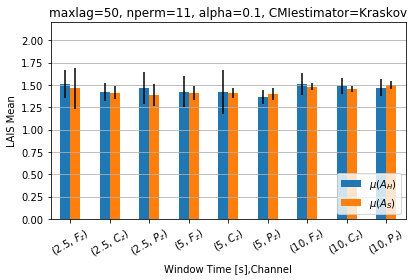

In [282]:
method = "Kraskov"
windows_time = []
for j, window_time_key in enumerate(["2.5", "5", "10"]):
    channels = []
    for i, i_channel_key in enumerate(["16", "17", "18"]):
        df = pd.DataFrame(results_dict[window_time_key][i_channel_key], columns=["H", "S"])
        channels.append([df.mean()["H"], df.std()["H"], df.mean()["S"], df.std()["S"]])
    df_channels = pd.DataFrame(channels, columns=[r"$\mu(A_H)$", r"$\sigma(A_H)$", r"$\mu(A_S)$", r"$\sigma(A_S)$"])
    df_channels.index = [r"$F_z$", r"$C_z$", r"$P_z$"]
    windows_time.append(df_channels) 
    
idx = pd.MultiIndex.from_product([['$2.5$', '$5$', '$10$'],
                                  ['$F_z$', '$C_z$', '$P_z$']],
                                 names=['Window Time [s]', 'Channel'])
table = pd.concat(windows_time).values
df_table = pd.DataFrame(table, idx, ["$\mu(A_H)$", "$\sigma(A_H)$", "$\mu(A_S)$", "$\sigma(A_S)$"])
caption = f"LAIS promedio para distintos largos de ventanas y canales. Settings: maxlag={max_lag}, nperm=11, alpha=0.1, CMIestimator=Kraskov"
print(df_table.to_latex(escape=False, float_format="%.2f", caption=caption))

fig, ax = plt.subplots()
caption = f"maxlag={max_lag}, nperm=11, alpha=0.1, CMIestimator={method}"
df_table[df_table.columns[[0, 2]]].plot(kind="bar", yerr=df_table[df_table.columns[[1, 3]]].T.values, ax=ax)
ax.grid(zorder=3, axis="y")
ax.set_title(caption)
ax.set_ylabel("LAIS Mean")
ax.legend(loc=4)
ax.set_ylim(0, 2.2)
plt.xticks(rotation=30)
fig.tight_layout()
fig.savefig(f"../results/LAISMean_maxlag-{max_lag}_{method}")
plt.show()

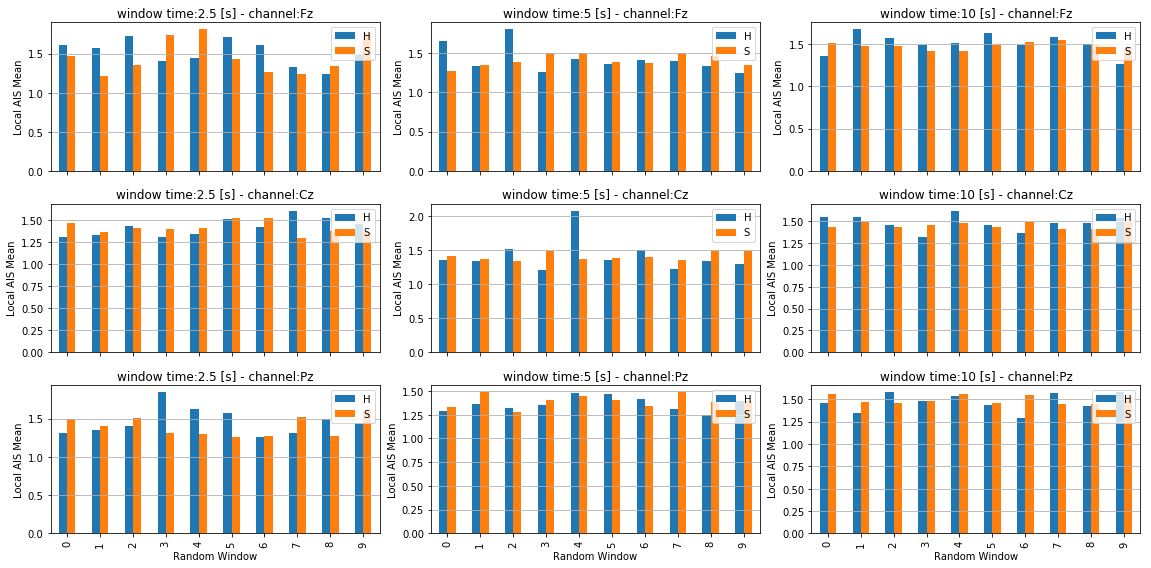

In [216]:
fig, axs = plt.subplots(3,3, figsize=(16,8), sharex=True)
for j, window_time_key in enumerate(["2.5", "5", "10"]):
    for i, i_channel_key in enumerate(["16", "17", "18"]):
        df = pd.DataFrame(results_dict[window_time_key][i_channel_key], columns=["H", "S"])
        df.plot(kind="bar", ax=axs[i, j], zorder=3)
        axs[i, j].set_title(f"window time:{window_time_key} [s] - channel:{ch_names[int(i_channel_key)]}")
        axs[i, j].grid(zorder=0, axis="y")
        axs[i, j].set_ylabel("Local AIS Mean")
        axs[i, j].set_xlabel("Random Window")
fig.tight_layout()
fig.savefig(f"../results/hist_lAIS_maxlag-{max_lag}.png", dpi=300)

# Transfer Entropy (TE)

In [ ]:
# Params for generating windows
window_time = 5
raw_edf = dataH

# Generated windows
data_windows, all_data = create_windows(raw_edf, time=window_time, band='alpha')
n_windows, n_channels, n_samples = data_windows.shape

In [ ]:
# Params for analysis
channels =  [16, 17, 18]
i_window = 0

# Setting for AIS calculation 

settings = {
    'cmi_estimator': 'JidtGaussianCMI',
    'max_lag_sources': 3,
    'min_lag_sources': 1,       
    'n_perm_max_stat': 11,
    'n_perm_min_stat': 11,
    'alpha_max_stat': 0.1,
    'n_perm_omnibus': 11,
    'alpha_omnibus': 0.1,
    'n_perm_max_seq': 11,
    'alpha_max_seq': 0.1, 
    'alpha_min_stat': 0.1,
    'verbose': False
}


# Calculating TE
net_analysis = analyse_network_by_metric(data_windows[i_window], channels, "TE", **settings)

In [ ]:
# Plotting
net_analysis.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=net_analysis, weights='max_te_lag', fdr=False)

plt.show()